In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path = untar_data(URLs.PETS); path

PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet')

In [6]:
path_anno = path/'annotations'
path_img = path/'images'

In [7]:
fnames = get_image_files(path_img)

np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224)
data.normalize(imagenet_stats)

# Train on freeze

In [16]:
learn = ConvLearner(data, models.resnet34, metrics=error_rate)

In [17]:
learn.lr_find(start_lr=1e-5,end_lr=30)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


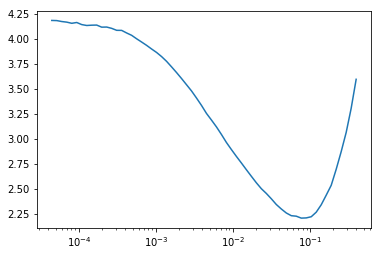

In [18]:
learn.recorder.plot()

In [ ]:
# which part of this model is trained?

In [33]:
# learn.layer_groups[-1]

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): AdaptiveMaxPool2d(output_size=1)
  (2): Lambda()
  (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Dropout(p=0.25)
  (5): Linear(in_features=1024, out_features=512, bias=True)
  (6): ReLU(inplace)
  (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Dropout(p=0.5)
  (9): Linear(in_features=512, out_features=37, bias=True)
)

In [19]:
learn.fit_one_cycle(3,max_lr=0.009)

Total time: 03:00
epoch  train_loss  valid_loss  error_rate
1      0.807444    0.694848    0.213573    (01:02)
2      0.595677    0.338857    0.113107    (00:58)
3      0.351435    0.239815    0.080506    (00:59)



In [23]:
# learn.lr_range(slice(1,4))

array([1., 2., 4.])

In [24]:
learn.save('freeze-3epochs')

# Train on unfreeze

In [26]:
learn.load('freeze-3epochs')

In [27]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


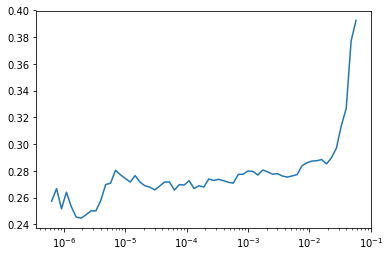

In [28]:
learn.recorder.plot()

In [29]:
len(learn.layer_groups)

3

In [32]:
learn.layer_groups[-2]

Sequential(
  (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

In [31]:
learn.layer_groups[-1]

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): AdaptiveMaxPool2d(output_size=1)
  (2): Lambda()
  (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Dropout(p=0.25)
  (5): Linear(in_features=1024, out_features=512, bias=True)
  (6): ReLU(inplace)
  (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Dropout(p=0.5)
  (9): Linear(in_features=512, out_features=37, bias=True)
)

In [34]:
learn.unfreeze() # unfreeze all 3 groups

In [35]:

learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

Total time: 03:24
epoch  train_loss  valid_loss  error_rate
1      0.264660    0.227796    0.078510    (01:08)
2      0.243155    0.211403    0.071191    (01:07)
3      0.229321    0.212965    0.071856    (01:08)



In [36]:
learn.save('unfreeze-3epochs')

# Freeze first group only

In [37]:
learn.load('unfreeze-3epochs')

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


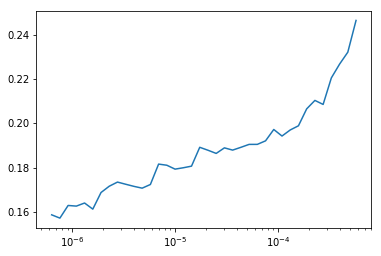

In [38]:
learn.lr_find()

learn.recorder.plot()

In [39]:
learn.freeze_to(-2) # freeze first group to speed up training

In [40]:

learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-5))

Total time: 05:04
epoch  train_loss  valid_loss  error_rate
1      0.202253    0.212518    0.070526    (01:00)
2      0.215585    0.206760    0.071191    (01:00)
3      0.200355    0.207170    0.067199    (01:00)
4      0.198802    0.200499    0.068530    (01:00)
5      0.195858    0.203000    0.066534    (01:01)



In [41]:
learn.save('freeze1st-5epochs')

# PCA on predictions

In [42]:
learn.load('freeze1st-5epochs')

In [43]:
raw_preds = learn.get_preds()

In [46]:
raw_preds[0].shape

torch.Size([1503, 37])

In [47]:
preds = to_np(raw_preds[0])

In [49]:
preds.shape

(1503, 37)

In [53]:
df = pd.DataFrame(preds)

In [61]:
from sklearn.decomposition import PCA

Exception ignored in: <function Learner.__del__ at 0x7f767a5d8048>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/python37/lib/python3.7/site-packages/fastai/basic_train.py", line 164, in __del__
    def __del__(self): del(self.model, self.data)
AttributeError: model


In [62]:
pca = PCA(n_components=2)

In [101]:
pca_res = pca.fit_transform(df)

In [102]:
pred_label = to_np(raw_preds[1])

In [111]:
pca_df = pd.DataFrame(np.hstack((pca_res,pred_label[:,None])),columns=['x','y','label'])

In [112]:
pca_df.head()

x          y  label
0 -11.078335  11.521496    1.0
1  19.697747   9.443859   11.0
2 -10.849675  -4.795476   13.0
3  10.046815  11.320602   16.0
4 -15.096373 -13.393976   13.0

In [114]:
pca_df.label = pca_df.label.astype('int8')

In [115]:
pca_df.dtypes

x        float64
y        float64
label       int8
dtype: object

In [116]:
import seaborn as sns

In [118]:
current_palette = sns.color_palette()

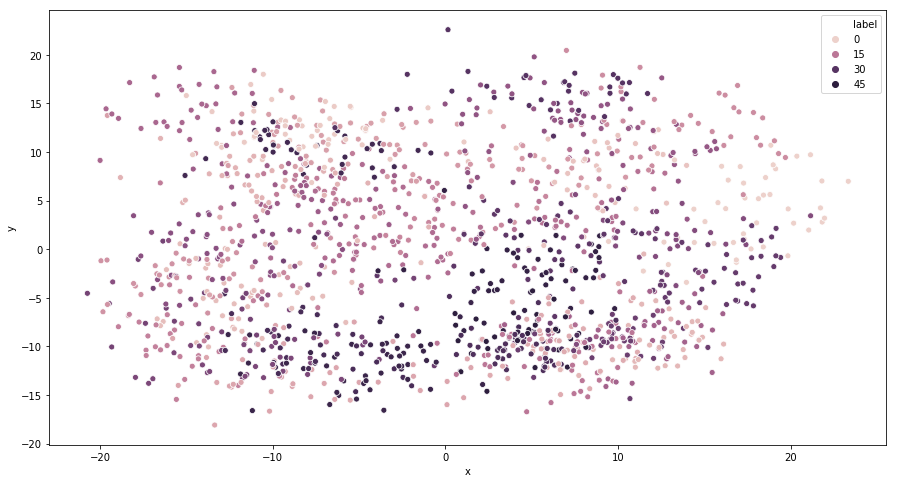

In [120]:
plt.figure(figsize=(15,8))
ax=sns.scatterplot(x="x", y="y",hue="label", data=pca_df)

# Meanshifts

Clustering technique that attemps to find dense areas of data points. Locate center points of each group with a sliding window: updating group's center points by finding the mean of all points within the window.

- Pros:

no need to specify number of clusters

converge towards points of maximum density
- Cons:

hypertuning radius of sliding window (windows size)

not highly scalable as it requires multiple nearest neighbor searches during execution

In [382]:
from sklearn.cluster import MeanShift, estimate_bandwidth
rs=42

In [413]:

bw = estimate_bandwidth(df,quantile=0.03,
                        random_state=rs,n_jobs=-1)
ms = MeanShift(bandwidth=bw, bin_seeding=True)
ms_cluster = ms.fit_predict(df)

In [414]:
pd.Series(ms_cluster).nunique()

16

In [415]:
ms_vc=pd.Series(ms_cluster).value_counts()
ms_vc

0     324
2     164
1     136
6     130
4     117
3     110
5     100
7      75
8      55
12     50
9      47
10     46
11     40
14     39
13     38
15     32
dtype: int64

In [416]:
ms_vc[ms_vc>=100].index.tolist()

[0, 2, 1, 6, 4, 3, 5]

In [419]:
ms_cluster = pd.Series(ms_cluster)

ms_cluster=ms_cluster[ms_cluster.isin(ms_vc[ms_vc>100].index.tolist())]

In [421]:
pca_df['cluster'] = ms_cluster


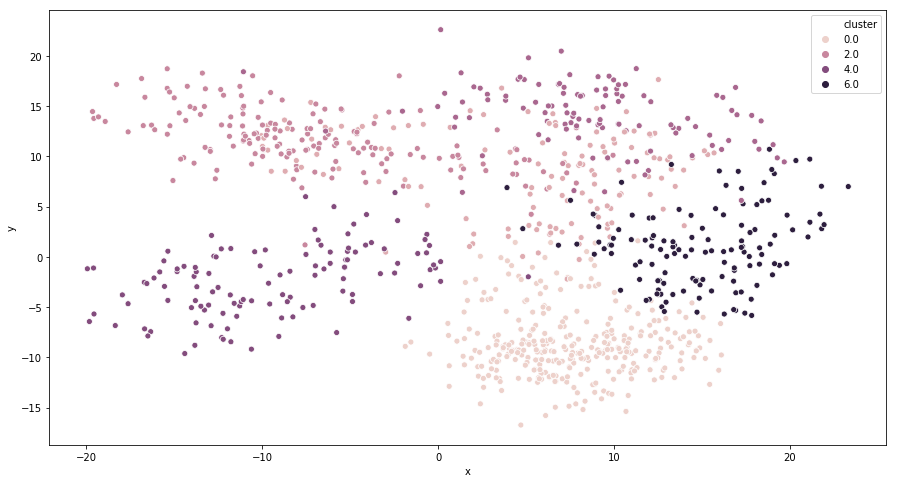

In [422]:
plt.figure(figsize=(15,8))
ax=sns.scatterplot(x="x", y="y",hue="cluster", data=pca_df)

## plot these clusters

In [428]:
def plot_clusters(n_col,clusters):
    cluster_label = pd.Series(clusters).unique()
    fig,axes = plt.subplots(len(cluster_label),n_col,figsize=(20,len(cluster_label)*2))
    
    for row,c in enumerate(cluster_label):
        idx = np.random.permutation(clusters[clusters==c].index.tolist())[:n_col]
        for col,img_i in enumerate(idx): 
            t = data.valid_ds[img_i]
            t[0].show(ax=axes[row][col], title=data.classes[data.valid_ds[img_i][1]])

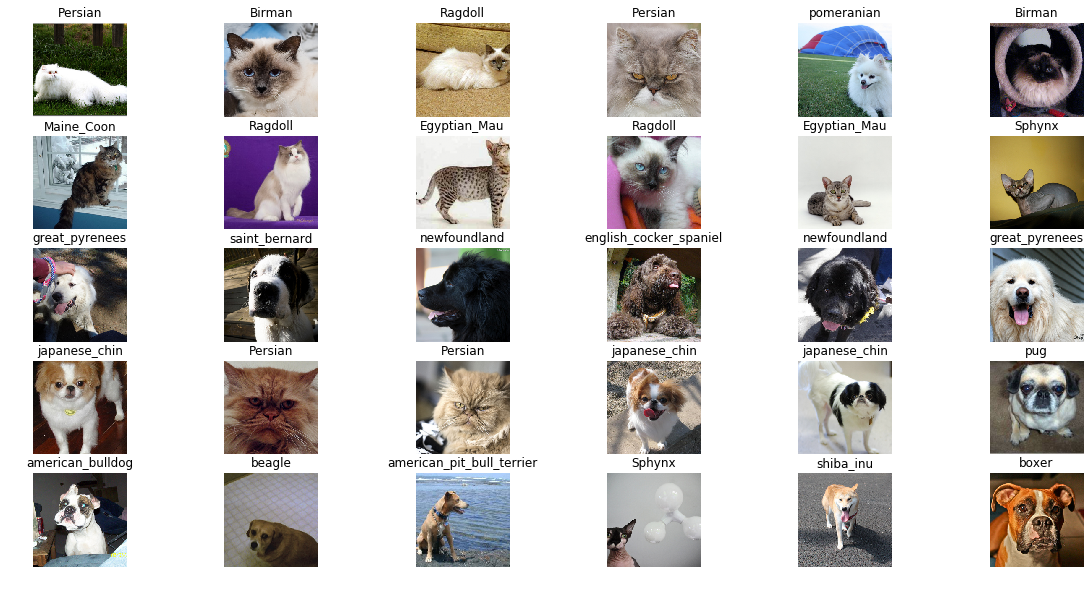

In [475]:
plot_clusters(6,ms_cluster)

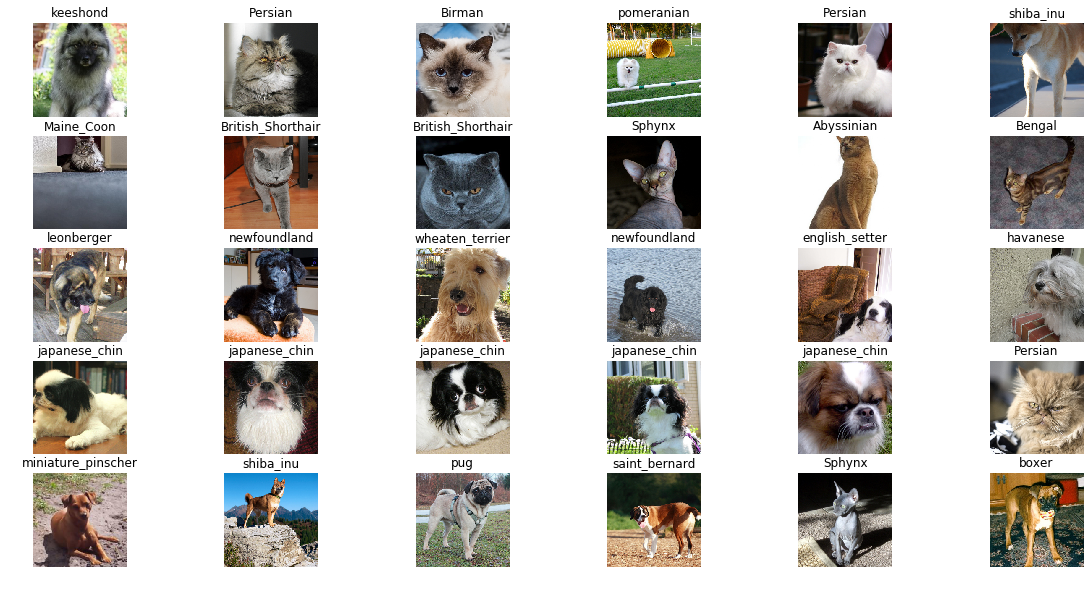

In [476]:
plot_clusters(6,ms_cluster)

# DBSCAN

DBSCAN transforms the space according to the density of the data: points in dense regions are left alone, while points in sparse regions are moved further away. Applying single linkage clustering to the transformed space results in a dendrogram, which we cut according to a distance parameter 

In [448]:
from sklearn.cluster import DBSCAN

In [449]:
df.shape

(1503, 37)

In [457]:
db = DBSCAN(eps=12, min_samples=10)
db_cluster = db.fit_predict(df)
pd.Series(db_cluster).nunique()

10

In [458]:
db_vc=pd.Series(db_cluster).value_counts()
db_vc

 5    508
 0    403
 2    167
 1    148
 7     79
-1     62
 6     42
 4     39
 3     38
 8     17
dtype: int64

In [459]:
db_vc[db_vc>=100].index.tolist()

[5, 0, 2, 1]

In [460]:
db_cluster = pd.Series(db_cluster)

db_cluster=db_cluster[db_cluster.isin(db_vc[db_vc>100].index.tolist())]

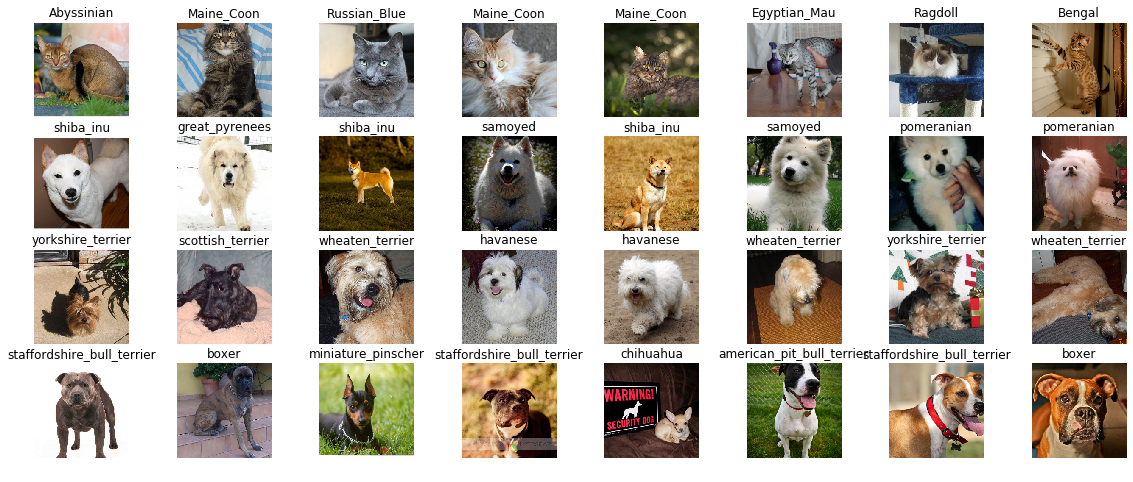

In [470]:
plot_clusters(8,db_cluster)

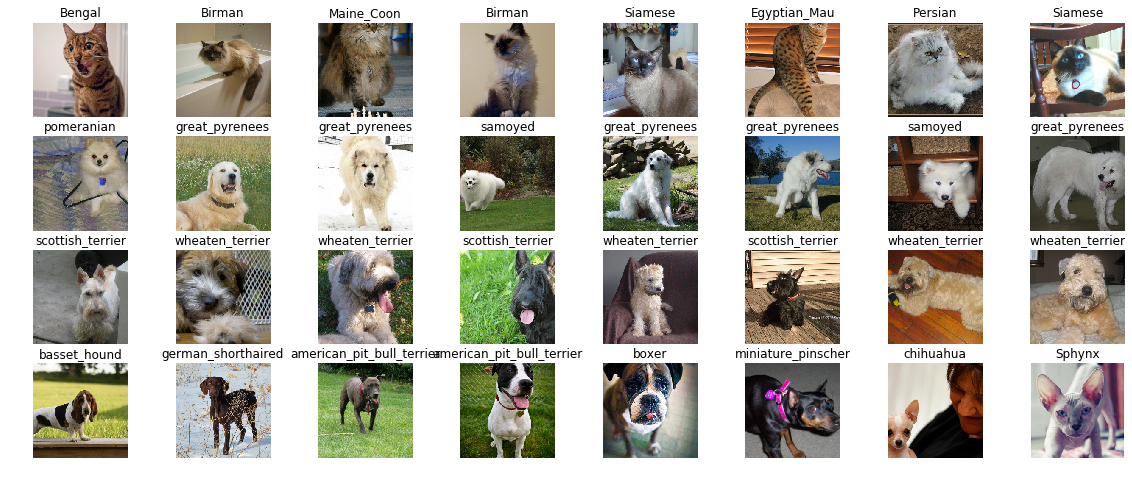

In [466]:
plot_clusters(8,db_cluster)